In [2]:
import os
import itertools, collections
import numpy, scipy, pandas
import scipy.signal
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from imp import reload
import seaborn

from pgtools import toolbox, myplots
import pygbrowse

import empdist
import peas
from peas.utilities import log_print

## Use empirical dataset

In [4]:
hic_corrs_fname = '/home/dskola/projects/coupled_peaks/hic/c57_hic_corrs_chr19.tsv'
hic_corrs = pandas.read_csv(hic_corrs_fname, sep='\t', index_col=0)

## Trim matrix

In [5]:
from peas.arrayfuncs import replace_nans_diagonal_means, compute_vector_trim_points, compute_matrix_trim_points, \
    create_diagonal_distance_matrix, create_data_masks

def trim_data_matrix(input_matrix):
    row_start_trim_point, row_end_trim_point, col_start_trim_point, col_end_trim_point = compute_matrix_trim_points(
        input_matrix)
    trimmed_matrix = input_matrix[row_start_trim_point:row_end_trim_point, col_start_trim_point:col_end_trim_point]
    log_print('trimmed {} x {} matrix to remove contiguous NaNs, now {} x {}.'.format(*input_matrix.shape,
                                                                                      *trimmed_matrix.shape))
    return trimmed_matrix

In [6]:
trimmed_corrs = replace_nans_diagonal_means(trim_data_matrix(hic_corrs.values))

2018-Aug-31 07:41:47	trimmed 6134 x 6134 matrix to remove contiguous NaNs, now 5825 x 5825.


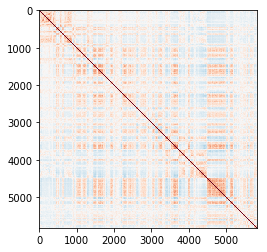

In [7]:
plt.imshow(trimmed_corrs, vmin=-0.5, vmax=0.5, cmap='RdBu_r')

In [131]:
%time real_means = peas.scoring.compute_mean_table_2d(trimmed_corrs, start_diagonal=2, end_diagonal=1000)

CPU times: user 2.29 s, sys: 164 ms, total: 2.45 s
Wall time: 2.45 s


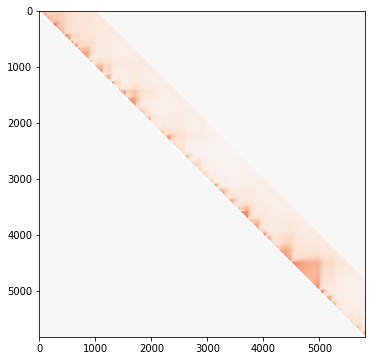

In [132]:
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(real_means, vmin=-0.5, vmax=0.5, cmap='RdBu_r')

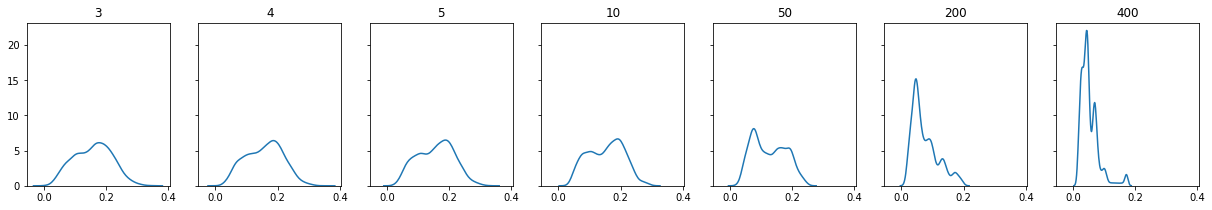

In [133]:
REGION_SIZES = (3, 4, 5, 10, 50, 200, 400)
fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=True, sharey=True)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = numpy.diag(real_means, region_size-1)
    seaborn.kdeplot(region_means, ax=ax)
    ax.set_title(region_size)

In [134]:
reload(peas)
reload(peas.scoring)
reload(peas.region_stats)

<module 'peas' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/__init__.py'>

In [135]:
target_pvalue = 1e-4
shuffles_needed = empdist.empirical_pval.compute_number_of_permuted_data_points(target_pvalue, 0.05) / trimmed_corrs.shape[0]
shuffles_needed

686.6951072961374

In [109]:
shuffled_means = peas.region_stats.generate_permuted_matrix_scores(trimmed_corrs, 
                                                                   num_shuffles=50, 
                                                                   min_region_size=3,
                                                                   start_diagonal=2,
                                                                   max_region_size=1000,
                                                                   random_seed=1)

2018-Aug-31 10:18:25			Setting random seed to 1
2018-Aug-31 10:18:25				permutation 1 of 50
2018-Aug-31 10:18:30				permutation 3 of 50
2018-Aug-31 10:18:36				permutation 5 of 50
2018-Aug-31 10:18:41				permutation 7 of 50
2018-Aug-31 10:18:47				permutation 9 of 50
2018-Aug-31 10:18:53				permutation 11 of 50
2018-Aug-31 10:18:58				permutation 13 of 50
2018-Aug-31 10:19:04				permutation 15 of 50
2018-Aug-31 10:19:10				permutation 17 of 50
2018-Aug-31 10:19:15				permutation 19 of 50
2018-Aug-31 10:19:21				permutation 21 of 50
2018-Aug-31 10:19:27				permutation 23 of 50
2018-Aug-31 10:19:33				permutation 25 of 50
2018-Aug-31 10:19:38				permutation 27 of 50
2018-Aug-31 10:19:44				permutation 29 of 50
2018-Aug-31 10:19:50				permutation 31 of 50
2018-Aug-31 10:19:55				permutation 33 of 50
2018-Aug-31 10:20:01				permutation 35 of 50
2018-Aug-31 10:20:07				permutation 37 of 50
2018-Aug-31 10:20:13				permutation 39 of 50
2018-Aug-31 10:20:18				permutation 41 of 50
2018-Aug-31 

In [110]:
%time shuffled_means = {size:numpy.sort(data) for size, data in shuffled_means.items()}

CPU times: user 5min 24s, sys: 25.1 s, total: 5min 49s
Wall time: 19 s


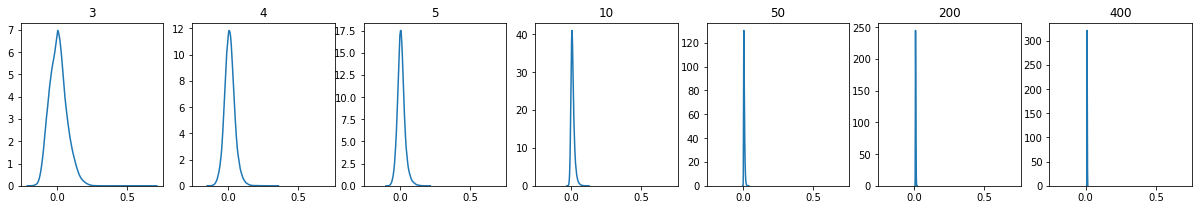

In [111]:
REGION_SIZES = (3, 4, 5, 10, 50, 200, 400)
fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=True, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    seaborn.kdeplot(region_means, ax=ax)
    ax.set_title(region_size)

In [112]:
reload(peas.fitapproxdistros.distributions)

<module 'peas.fitapproxdistros.distributions' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/fitapproxdistros/distributions.py'>

In [113]:
def plot_fit_params(param_dict, param_names, fig_height=3):
    param_df = pandas.DataFrame(param_dict, index=param_names).T

    fig, axes = plt.subplots(1, len(param_names), figsize=(fig_height*len(param_names),fig_height))
    for ax_idx, param_name in enumerate(param_names):
        axes[ax_idx].plot(param_df[param_name])
        axes[ax_idx].set_title(param_name)
        axes[ax_idx].set_ylabel('Value')
        axes[ax_idx].set_xlabel('Sample size')
    fig.tight_layout()
    return fig

In [114]:
reload(peas.fitapproxdistros.distributions)

<module 'peas.fitapproxdistros.distributions' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/fitapproxdistros/distributions.py'>

In [115]:
null_params = peas.fitapproxdistros.helper_funcs.fit_distros(shuffled_means, 
                                                             peas.fitapproxdistros.distributions.PiecewiseApproxPower,
                                                             parameter_smoothing_window_size=5)
null_param_df = pandas.DataFrame(null_params, index=['inflection_point', 'power', 'scale']).T

2018-Aug-31 10:21:07			size: 3 fit parameters: (-0.10252392954222647, 1.9777585549861112, -58.19867343584231)
2018-Aug-31 10:21:08			size: 4 fit parameters: (-0.025900891479178758, 1.298759431368864, -59.76486591339904)
2018-Aug-31 10:21:08			size: 5 fit parameters: (-0.01670674826853157, 1.2131103337041134, -68.58743084086584)
2018-Aug-31 10:21:09			size: 6 fit parameters: (-0.010800194347617725, 1.1484261578299484, -74.65030419665459)
2018-Aug-31 10:21:09			size: 7 fit parameters: (-0.007125419653569615, 1.1040677514188502, -79.74027841299745)
2018-Aug-31 10:21:10			size: 8 fit parameters: (-0.004798323164330388, 1.0727959552801174, -84.01519149875367)
2018-Aug-31 10:21:10			size: 9 fit parameters: (-0.003214613675371022, 1.0629956138241625, -91.50457295700848)
2018-Aug-31 10:21:11			size: 10 fit parameters: (-0.001863587071145338, 1.0443327546763432, -95.55970117398651)
2018-Aug-31 10:21:11			size: 11 fit parameters: (-0.0009674413352494965, 1.039445037247062, -102.26858547254247)
2

2018-Aug-31 10:21:47			size: 77 fit parameters: (0.006199551254111551, 1.3302377198294804, -1447.3059531138322)
2018-Aug-31 10:21:48			size: 78 fit parameters: (0.00620417397580838, 1.3368718745289543, -1502.0492468671962)
2018-Aug-31 10:21:48			size: 79 fit parameters: (0.006241748185802044, 1.335479427275464, -1509.8958986239422)
2018-Aug-31 10:21:49			size: 80 fit parameters: (0.006239412333719351, 1.3436266717919698, -1576.2344164522863)
2018-Aug-31 10:21:49			size: 81 fit parameters: (0.006265102591939226, 1.3445703117223216, -1598.627772185051)
2018-Aug-31 10:21:50			size: 82 fit parameters: (0.006275012497813795, 1.3493950224107356, -1646.7476907567063)
2018-Aug-31 10:21:50			size: 83 fit parameters: (0.0063107356728693866, 1.347737836127938, -1652.6900812467484)
2018-Aug-31 10:21:51			size: 84 fit parameters: (0.006325108599061437, 1.3515503455605824, -1695.920857966206)
2018-Aug-31 10:21:51			size: 85 fit parameters: (0.006327641380775498, 1.3588808682827582, -1765.60167225116

2018-Aug-31 10:22:25			size: 151 fit parameters: (0.006821801455024669, 1.630987143304334, -9624.609958019126)
2018-Aug-31 10:22:26			size: 152 fit parameters: (0.006830175955115246, 1.6331226165650043, -9779.065377719393)
2018-Aug-31 10:22:26			size: 153 fit parameters: (0.006834656166849393, 1.6364709927303271, -9986.012826320635)
2018-Aug-31 10:22:26			size: 154 fit parameters: (0.0068412442860839, 1.6385570675498822, -10137.818205044992)
2018-Aug-31 10:22:27			size: 155 fit parameters: (0.006838625066369447, 1.6448132973009486, -10483.348871316872)
2018-Aug-31 10:22:27			size: 156 fit parameters: (0.006851841325350758, 1.644633580038433, -10542.333841770318)
2018-Aug-31 10:22:28			size: 157 fit parameters: (0.006849753285576974, 1.6505083371974665, -10882.589716774026)
2018-Aug-31 10:22:28			size: 158 fit parameters: (0.0068421939564630085, 1.6584350354301658, -11334.08841226256)
2018-Aug-31 10:22:29			size: 159 fit parameters: (0.006852845941598775, 1.6588871096085978, -11424.4600

2018-Aug-31 10:22:57			size: 225 fit parameters: (0.006553649863292456, 2.1087972570380735, -119005.77996425971)
2018-Aug-31 10:22:58			size: 226 fit parameters: (0.006529083693627793, 2.1247267691547265, -128165.17026487405)
2018-Aug-31 10:22:58			size: 227 fit parameters: (0.006507868284702422, 2.1390191005812142, -137024.2226300828)
2018-Aug-31 10:22:59			size: 228 fit parameters: (0.006490418458131876, 2.1514641983241374, -145335.6390331814)
2018-Aug-31 10:22:59			size: 229 fit parameters: (0.0064933846527632485, 2.1549981537874188, -148429.07319661995)
2018-Aug-31 10:23:00			size: 230 fit parameters: (0.006505679391282933, 2.1539923329648567, -148663.69347238797)
2018-Aug-31 10:23:00			size: 231 fit parameters: (0.006505692943842165, 2.158319787505266, -152272.74733286366)
2018-Aug-31 10:23:00			size: 232 fit parameters: (0.006501337153516576, 2.1645701911643362, -157229.65448579745)
2018-Aug-31 10:23:01			size: 233 fit parameters: (0.006499371079956871, 2.169476877110667, -161403

2018-Aug-31 10:23:29			size: 299 fit parameters: (0.006859415518914861, 2.207636954142849, -252183.19152459092)
2018-Aug-31 10:23:29			size: 300 fit parameters: (0.0068608993518162785, 2.209809024305217, -255543.60858611393)
2018-Aug-31 10:23:30			size: 301 fit parameters: (0.00686627979087968, 2.2098964846513147, -256635.99059905286)
2018-Aug-31 10:23:30			size: 302 fit parameters: (0.006851109732101844, 2.220676072533974, -270035.7510245462)
2018-Aug-31 10:23:31			size: 303 fit parameters: (0.006847215500891997, 2.2256759650455993, -277088.9948780042)
2018-Aug-31 10:23:31			size: 304 fit parameters: (0.006822425005897818, 2.241566431990662, -298169.74645170325)
2018-Aug-31 10:23:31			size: 305 fit parameters: (0.006819903610768414, 2.2462250207188657, -305579.0678619263)
2018-Aug-31 10:23:32			size: 306 fit parameters: (0.006803697433860969, 2.2574875556935052, -322168.2651982317)
2018-Aug-31 10:23:32			size: 307 fit parameters: (0.006806659266258625, 2.2582544640729982, -324263.6853

2018-Aug-31 10:24:17			size: 373 fit parameters: (0.0071712681724147315, 2.2220787646987787, -343625.65891536325)
2018-Aug-31 10:24:18			size: 374 fit parameters: (0.007186871766814918, 2.215299744429182, -334335.11625138746)
2018-Aug-31 10:24:19			size: 375 fit parameters: (0.007186580015107679, 2.217480180106719, -338588.9474738374)
2018-Aug-31 10:24:19			size: 376 fit parameters: (0.007203213009396366, 2.2101562732275815, -328624.2364055733)
2018-Aug-31 10:24:20			size: 377 fit parameters: (0.007205904619118488, 2.2110002780661304, -330919.85197536997)
2018-Aug-31 10:24:21			size: 378 fit parameters: (0.00722044508542765, 2.2043237291346203, -321954.95899330126)
2018-Aug-31 10:24:22			size: 379 fit parameters: (0.007222463171618343, 2.205750909764512, -325134.0209909341)
2018-Aug-31 10:24:22			size: 380 fit parameters: (0.007227263831681406, 2.2051921254703495, -325246.3822240819)
2018-Aug-31 10:24:23			size: 381 fit parameters: (0.00723238069017993, 2.204182446121178, -324705.17916

2018-Aug-31 10:25:10			size: 447 fit parameters: (0.007552664421717974, 2.1451992113527143, -298246.30950340943)
2018-Aug-31 10:25:11			size: 448 fit parameters: (0.0075534350020536505, 2.1461150093754076, -300144.9503787146)
2018-Aug-31 10:25:12			size: 449 fit parameters: (0.007567581395668052, 2.1391605050929403, -291499.1514460843)
2018-Aug-31 10:25:12			size: 450 fit parameters: (0.007571364429339998, 2.1385106017647284, -291324.00945250556)
2018-Aug-31 10:25:13			size: 451 fit parameters: (0.007590206902704212, 2.127703360070375, -277706.06751734775)
2018-Aug-31 10:25:14			size: 452 fit parameters: (0.007599203129207427, 2.1234985322075257, -272987.8093476608)
2018-Aug-31 10:25:15			size: 453 fit parameters: (0.007600543451644506, 2.124476847995501, -274910.063184126)
2018-Aug-31 10:25:15			size: 454 fit parameters: (0.007605653929140719, 2.1229264674887567, -273607.1039444624)
2018-Aug-31 10:25:16			size: 455 fit parameters: (0.007610569043782103, 2.1214439889821195, -272398.122

2018-Aug-31 10:26:05			size: 521 fit parameters: (0.008056651852272056, 1.9174720350905199, -119426.01226819618)
2018-Aug-31 10:26:06			size: 522 fit parameters: (0.008064407909581616, 1.9131388424469304, -117176.21393052803)
2018-Aug-31 10:26:07			size: 523 fit parameters: (0.008073738016625814, 1.9078267299035483, -114436.029980009)
2018-Aug-31 10:26:07			size: 524 fit parameters: (0.008077478465772088, 1.9070167394479114, -114259.68368745192)
2018-Aug-31 10:26:08			size: 525 fit parameters: (0.008085430092984434, 1.9027777392850913, -112185.45319800968)
2018-Aug-31 10:26:09			size: 526 fit parameters: (0.008086137375750719, 1.9038846129801896, -113028.70560713638)
2018-Aug-31 10:26:10			size: 527 fit parameters: (0.008094280187693882, 1.8998686861544503, -111128.93783284473)
2018-Aug-31 10:26:10			size: 528 fit parameters: (0.008099885684459395, 1.897454200555382, -110091.50901077651)
2018-Aug-31 10:26:11			size: 529 fit parameters: (0.008102127491675357, 1.897538103500545, -110394.

2018-Aug-31 10:27:00			size: 594 fit parameters: (0.008308921067426213, 1.846680430270048, -99126.7519470145)
2018-Aug-31 10:27:01			size: 595 fit parameters: (0.00831213252105139, 1.8460335055872188, -99051.5843906153)
2018-Aug-31 10:27:01			size: 596 fit parameters: (0.008313693188242814, 1.846457590011065, -99474.63845055689)
2018-Aug-31 10:27:02			size: 597 fit parameters: (0.008312386205298079, 1.8490421808683557, -100969.95061625031)
2018-Aug-31 10:27:03			size: 598 fit parameters: (0.008312652903271957, 1.8505468822724402, -101955.88748086242)
2018-Aug-31 10:27:04			size: 599 fit parameters: (0.008309883327208018, 1.8546886790677988, -104327.96938486476)
2018-Aug-31 10:27:04			size: 600 fit parameters: (0.008308952806703232, 1.8572147676409159, -105885.60113360475)
2018-Aug-31 10:27:05			size: 601 fit parameters: (0.00831079219254594, 1.8573303708149542, -106175.3767995465)
2018-Aug-31 10:27:06			size: 602 fit parameters: (0.008309456867955431, 1.8600334126847784, -107823.637841

2018-Aug-31 10:27:53			size: 667 fit parameters: (0.008405917041756784, 1.8877451427059286, -142287.68879101353)
2018-Aug-31 10:27:54			size: 668 fit parameters: (0.0084105676378205, 1.8860067800893772, -141447.93951083746)
2018-Aug-31 10:27:55			size: 669 fit parameters: (0.008406437669561676, 1.8910025332097682, -145307.64314855065)
2018-Aug-31 10:27:55			size: 670 fit parameters: (0.008412875980762123, 1.8873383181105596, -142994.30287433031)
2018-Aug-31 10:27:56			size: 671 fit parameters: (0.0084161897966669, 1.886444985903424, -142705.2433188754)
2018-Aug-31 10:27:57			size: 672 fit parameters: (0.008416980588961653, 1.8871222917314137, -143455.85757622746)
2018-Aug-31 10:27:57			size: 673 fit parameters: (0.008421059097196497, 1.8854591942441117, -142578.87198386897)
2018-Aug-31 10:27:58			size: 674 fit parameters: (0.008418957185086747, 1.8890376326563834, -145491.11207104736)
2018-Aug-31 10:27:59			size: 675 fit parameters: (0.008424643273913617, 1.8858790333768785, -143522.34

2018-Aug-31 10:28:46			size: 741 fit parameters: (0.008546123669622721, 1.871855047617354, -151197.26333871947)
2018-Aug-31 10:28:47			size: 742 fit parameters: (0.008558895757964114, 1.862041909597365, -144141.85019553138)
2018-Aug-31 10:28:47			size: 743 fit parameters: (0.00855204276676041, 1.8695159719629681, -149969.87528070254)
2018-Aug-31 10:28:48			size: 744 fit parameters: (0.008562067300753253, 1.861616080255795, -144294.1611144209)
2018-Aug-31 10:28:49			size: 745 fit parameters: (0.008566486245325328, 1.859367517939476, -142953.38897663393)
2018-Aug-31 10:28:50			size: 746 fit parameters: (0.008565722821167791, 1.8609656178247047, -144318.9807280298)
2018-Aug-31 10:28:50			size: 747 fit parameters: (0.008555137476022224, 1.8718440017721458, -152766.1274403984)
2018-Aug-31 10:28:51			size: 748 fit parameters: (0.008561985337174451, 1.8666401995668351, -148996.7461125356)
2018-Aug-31 10:28:52			size: 749 fit parameters: (0.008559874855226786, 1.869830974782715, -151670.448363

2018-Aug-31 10:29:39			size: 815 fit parameters: (0.008517691686805936, 1.9824166239305012, -296685.5752087035)
2018-Aug-31 10:29:40			size: 816 fit parameters: (0.008514390906329963, 1.9866994352628666, -303680.3763945154)
2018-Aug-31 10:29:40			size: 817 fit parameters: (0.00852109650697113, 1.9815988752917955, -296420.8334355297)
2018-Aug-31 10:29:41			size: 818 fit parameters: (0.008525834173867599, 1.9780552350946567, -291597.46630976873)
2018-Aug-31 10:29:42			size: 819 fit parameters: (0.008527420326101888, 1.9779354494239814, -291907.76860654674)
2018-Aug-31 10:29:42			size: 820 fit parameters: (0.008525405907499268, 1.9809240218966582, -296800.2449846576)
2018-Aug-31 10:29:43			size: 821 fit parameters: (0.008520342641809382, 1.9868604609040599, -306371.11534783687)
2018-Aug-31 10:29:44			size: 822 fit parameters: (0.008522115282570544, 1.986187015652508, -305738.1655590545)
2018-Aug-31 10:29:45			size: 823 fit parameters: (0.008524511215200913, 1.9848282542537574, -304061.213

2018-Aug-31 10:30:30			size: 889 fit parameters: (0.008355845327893309, 2.23166504036004, -1177583.0405599952)
2018-Aug-31 10:30:30			size: 890 fit parameters: (0.00835519775206307, 2.233475856168306, -1190331.682966874)
2018-Aug-31 10:30:31			size: 891 fit parameters: (0.008351693930057183, 2.2384596311871037, -1222758.2538531534)
2018-Aug-31 10:30:32			size: 892 fit parameters: (0.008356830099471382, 2.2344658254738254, -1200253.079620916)
2018-Aug-31 10:30:32			size: 893 fit parameters: (0.008353117213936754, 2.2395660018237358, -1233709.0434611381)
2018-Aug-31 10:30:33			size: 894 fit parameters: (0.008358700241824458, 2.2354543450796456, -1210648.5450993753)
2018-Aug-31 10:30:34			size: 895 fit parameters: (0.008350607458137668, 2.2446091837803435, -1269510.4975969093)
2018-Aug-31 10:30:34			size: 896 fit parameters: (0.00836425177520333, 2.232645916885838, -1197884.2891391467)
2018-Aug-31 10:30:35			size: 897 fit parameters: (0.008369682549571678, 2.228124152283198, -1172509.8389

2018-Aug-31 10:31:21			size: 963 fit parameters: (0.008529520110206511, 2.140032017365564, -829623.4971256373)
2018-Aug-31 10:31:22			size: 964 fit parameters: (0.008534470928426203, 2.1358950241580814, -813373.1244821151)
2018-Aug-31 10:31:23			size: 965 fit parameters: (0.008527556849898081, 2.144414753065706, -851005.552174333)
2018-Aug-31 10:31:23			size: 966 fit parameters: (0.008531562028579185, 2.140891958914907, -836643.1480233835)
2018-Aug-31 10:31:24			size: 967 fit parameters: (0.00852702454450742, 2.1468268207655705, -863776.5234587962)
2018-Aug-31 10:31:25			size: 968 fit parameters: (0.008529808258061372, 2.14498838510649, -856929.7305780996)
2018-Aug-31 10:31:25			size: 969 fit parameters: (0.008521437588939175, 2.1545163486328436, -900666.0654129686)
2018-Aug-31 10:31:26			size: 970 fit parameters: (0.008518074885717564, 2.1592479032854426, -924128.4379562124)
2018-Aug-31 10:31:27			size: 971 fit parameters: (0.008517579216035352, 2.160813791687145, -932950.9748990543)


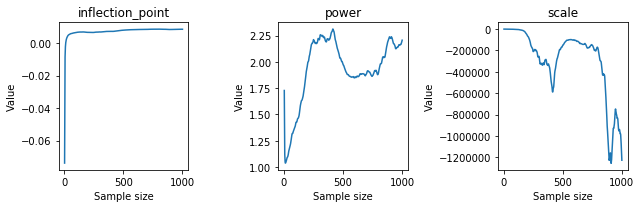

In [116]:
fig = plot_fit_params(null_params, ['inflection_point', 'power', 'scale'])

In [117]:
REGION_SIZES = (3, 4, 5, 10, 20, 50, 100, 200, 500, 1000)

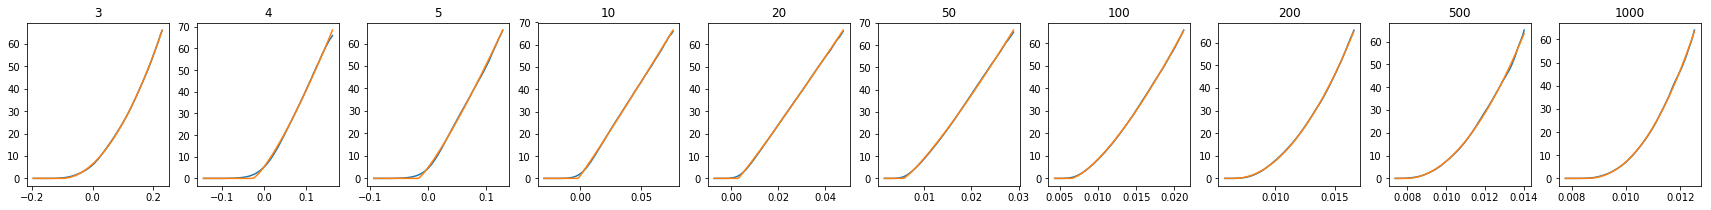

In [118]:
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
    empirical_pvals = empdist.empirical_pval.compute_empirical_pvalue(region_means, xs, is_sorted=True, tail='right')
    pscores = -10 * numpy.log(empirical_pvals)
#     ax.plot(xs, pscores)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    ax.plot(fit_xs, -10 * fit_ys)

    ax.plot(fit_xs, -10 * fit_distro.logsf(fit_xs))
    
    ax.set_title(region_size)

## Compare to Norm

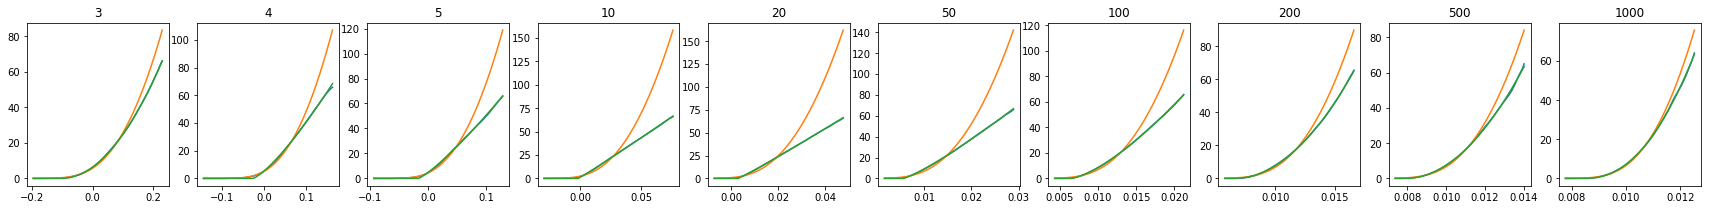

In [119]:
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
#     empirical_pvals = empdist.empirical_pval.compute_empirical_pvalue(region_means, xs, is_sorted=True, tail='right')
#     pscores = -10 * numpy.log(empirical_pvals)
#     ax.plot(xs, pscores)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)
    
    ax.plot(fit_xs, -10 * fit_ys)

    ax.plot(fit_xs, -10 * norm_distro.logsf(fit_xs))
    
    ax.plot(fit_xs, -10 * fit_distro.logsf(fit_xs))
    
    
    ax.set_title(region_size)

## Q-Q plot

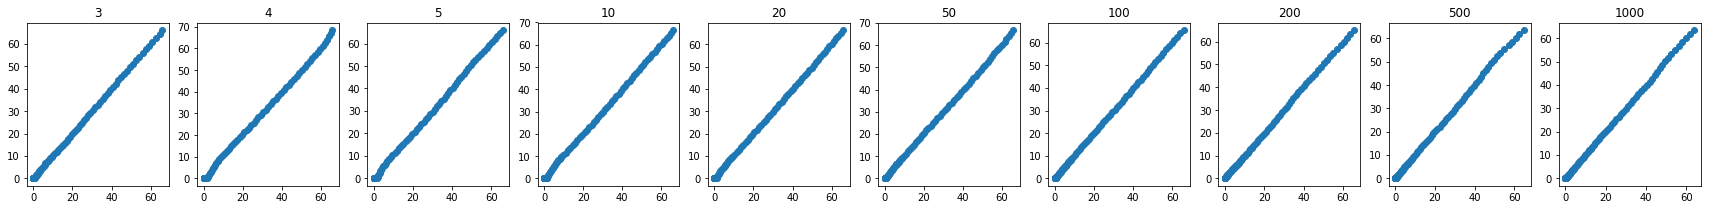

In [120]:
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
#     empirical_pvals = empdist.empirical_pval.compute_empirical_pvalue(region_means, xs, is_sorted=True, tail='right')
#     pscores = -10 * numpy.log(empirical_pvals)
#     ax.plot(xs, pscores)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)
    
    ax.scatter(-10*fit_ys, -10 * fit_distro.logsf(fit_xs))

#     ax.plot(fit_xs, -10 * norm_distro.logsf(fit_xs))
    
#     ax.plot(fit_xs, -10 * fit_distro.logsf(fit_xs))
    
    
    ax.set_title(region_size)

In [121]:
def square_ax(ax):
    joint_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
    joint_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim((joint_min, joint_max))
    ax.set_ylim((joint_min, joint_max))

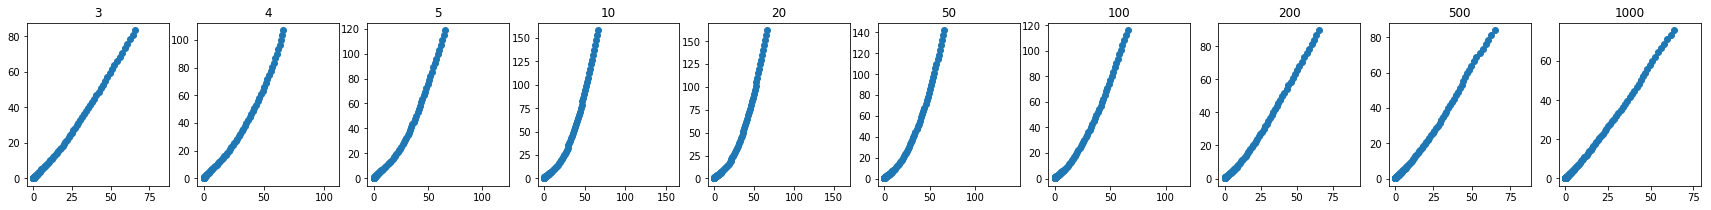

In [122]:
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
#     empirical_pvals = empdist.empirical_pval.compute_empirical_pvalue(region_means, xs, is_sorted=True, tail='right')
#     pscores = -10 * numpy.log(empirical_pvals)
#     ax.plot(xs, pscores)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)
    
    ax.scatter(-10*fit_ys, -10 * norm_distro.logsf(fit_xs))
    square_ax(ax)

    ax.set_title(region_size)

In [ ]:
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)
    
    ax.scatter(-10*fit_ys, -10 * norm_distro.logsf(fit_xs), s=10)
    ax.scatter(-10*fit_ys, -10 * fit_distro.logsf(fit_xs), s=10)

    square_ax(ax)

    ax.set_title(region_size)

/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/fitapproxdistros/distributions.py:13: RuntimeWarning:

divide by zero encountered in double_scalars



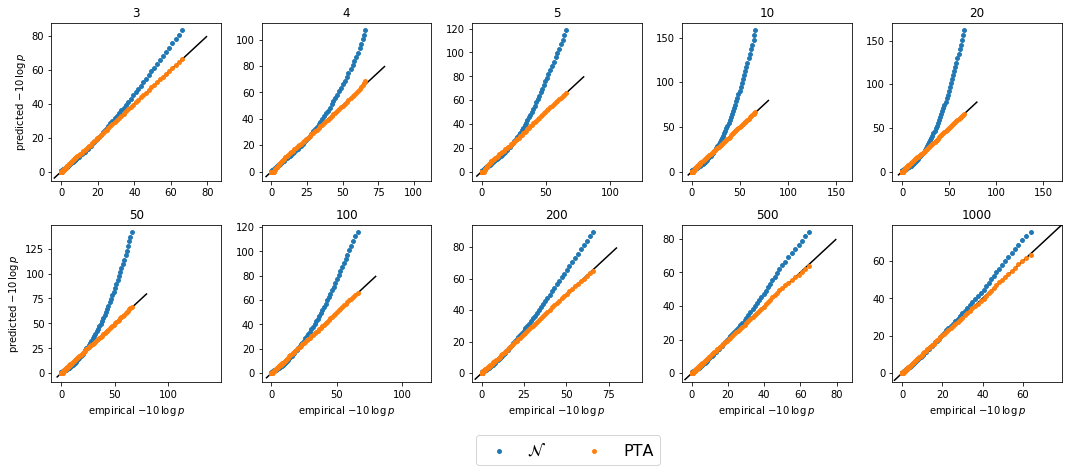

In [123]:
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3

from pgtools.toolbox import Raveller
r = Raveller(9999, 5)

_, rows, _ = r.unravel(len(REGION_SIZES))

fig, axes = plt.subplots(rows, r.cols_per_row, 
                         figsize=(fig_size * r.cols_per_row, fig_size * rows),
                         sharex=False, sharey=False)

for region_idx, region_size in enumerate(REGION_SIZES):
    _, plot_row, plot_col = r.unravel(region_idx)
    this_ax = axes[plot_row, plot_col]
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)

    this_ax.scatter(-10*fit_ys, -10 * norm_distro.logsf(fit_xs), s=15, zorder=3, label='$\mathcal{N}$')
    this_ax.scatter(-10*fit_ys, -10 * fit_distro.logsf(fit_xs), s=15, zorder=3, label='PTA')

    square_ax(this_ax)

    this_ax.plot(*zip(*zip(ax.get_xlim(), ax.get_ylim())), color='k')

    this_ax.set_title(region_size)
    
    if plot_col == 0:
        this_ax.set_ylabel('predicted $-10 \, \log \, p$')
    if plot_row == rows - 1:
        this_ax.set_xlabel('empirical $-10 \, \log \, p$')        
    
    
fig.tight_layout()
axes[0,0].legend(loc=(2.5, -1.8), ncol=2, fontsize=16)

## ToDo: Redo using a big set of permutations as ground truth

## Generate distributions and move on

In [124]:
null_distributions = peas.region_stats.fit_distributions(shuffled_means,
                                                         distribution_class=peas.fitapproxdistros.distributions.PiecewiseApproxPower, 
                                                         parameter_smoothing_window_size=5)

2018-Aug-31 10:32:20		Fitting distributions of class <class 'peas.fitapproxdistros.distributions.PiecewiseApproxPower'>
2018-Aug-31 10:32:20			size: 3 fit parameters: (-0.10252413959509503, 1.977761069803925, -58.19877385544958)
2018-Aug-31 10:32:21			size: 4 fit parameters: (-0.02590091295795766, 1.2987597132212145, -59.76488564027685)
2018-Aug-31 10:32:21			size: 5 fit parameters: (-0.01670675343036278, 1.2131103256777531, -68.58742404704313)
2018-Aug-31 10:32:21			size: 6 fit parameters: (-0.010800205004083765, 1.148426492037506, -74.6503542596879)
2018-Aug-31 10:32:22			size: 7 fit parameters: (-0.007125427386872779, 1.1040680691890032, -79.7403350384862)
2018-Aug-31 10:32:22			size: 8 fit parameters: (-0.00479832179270781, 1.0727961550537743, -84.01524227906152)
2018-Aug-31 10:32:23			size: 9 fit parameters: (-0.003214619249451957, 1.0629959933062234, -91.50466297010638)
2018-Aug-31 10:32:23			size: 10 fit parameters: (-0.0018635782203730918, 1.0443323522714498, -95.55960721430304

2018-Aug-31 10:32:59			size: 76 fit parameters: (0.00620050752094811, 1.3221683018583377, -1386.3672767032804)
2018-Aug-31 10:32:59			size: 77 fit parameters: (0.006199518370165083, 1.3302426898755022, -1447.3314454354627)
2018-Aug-31 10:33:00			size: 78 fit parameters: (0.006204178399891325, 1.3368713685826574, -1502.0467955219165)
2018-Aug-31 10:33:00			size: 79 fit parameters: (0.006241751195698977, 1.3354784837666598, -1509.8901236498202)
2018-Aug-31 10:33:00			size: 80 fit parameters: (0.006239421895022967, 1.34362416213669, -1576.2187389995997)
2018-Aug-31 10:33:01			size: 81 fit parameters: (0.006265116714325977, 1.344569040186997, -1598.621975351101)
2018-Aug-31 10:33:02			size: 82 fit parameters: (0.006275018847257686, 1.349394314188635, -1646.7439965378921)
2018-Aug-31 10:33:02			size: 83 fit parameters: (0.0063107421562866315, 1.3477366293724813, -1652.6826494703757)
2018-Aug-31 10:33:03			size: 84 fit parameters: (0.006325115620455949, 1.3515484741198787, -1695.908222492894

2018-Aug-31 10:33:38			size: 150 fit parameters: (0.006815375654191884, 1.6278947635013723, -9431.048885145528)
2018-Aug-31 10:33:39			size: 151 fit parameters: (0.006821799021838349, 1.6309877541272968, -9624.632926768341)
2018-Aug-31 10:33:39			size: 152 fit parameters: (0.006830178016813134, 1.633121230469027, -9779.004181478796)
2018-Aug-31 10:33:40			size: 153 fit parameters: (0.006834640119321618, 1.6364766428460764, -9986.24893949486)
2018-Aug-31 10:33:41			size: 154 fit parameters: (0.0068412462673309166, 1.6385559139252288, -10137.766003407989)
2018-Aug-31 10:33:41			size: 155 fit parameters: (0.0068386341933412255, 1.6448085409830153, -10483.12875313843)
2018-Aug-31 10:33:42			size: 156 fit parameters: (0.0068518811742502425, 1.6446240653120525, -10541.947701517865)
2018-Aug-31 10:33:42			size: 157 fit parameters: (0.006849744333058108, 1.6505101312951982, -10882.660877002156)
2018-Aug-31 10:33:43			size: 158 fit parameters: (0.006842192765105628, 1.6584353644099468, -11334.1

2018-Aug-31 10:34:15			size: 224 fit parameters: (0.00654647323154445, 2.10760846972814, -117741.79745535273)
2018-Aug-31 10:34:16			size: 225 fit parameters: (0.00655366825950589, 2.108792734971465, -119003.83110775582)
2018-Aug-31 10:34:16			size: 226 fit parameters: (0.006529092756058861, 2.124721110029604, -128161.94318311632)
2018-Aug-31 10:34:16			size: 227 fit parameters: (0.0065078615725405525, 2.1390224441747403, -137026.19602518145)
2018-Aug-31 10:34:17			size: 228 fit parameters: (0.006490509297430719, 2.1514312278195287, -145316.24400669022)
2018-Aug-31 10:34:17			size: 229 fit parameters: (0.006493379986683416, 2.1549987534320416, -148429.27975056108)
2018-Aug-31 10:34:18			size: 230 fit parameters: (0.006505687569169606, 2.1539882852536802, -148661.10597226073)
2018-Aug-31 10:34:18			size: 231 fit parameters: (0.006505698291559885, 2.15831705383805, -152270.94842690637)
2018-Aug-31 10:34:19			size: 232 fit parameters: (0.006501400322240495, 2.164547082868105, -157214.9399

2018-Aug-31 10:34:48			size: 298 fit parameters: (0.006854806604082292, 2.206825460883491, -250239.68136986828)
2018-Aug-31 10:34:49			size: 299 fit parameters: (0.006859392596205774, 2.2076493676609155, -252196.91672648521)
2018-Aug-31 10:34:49			size: 300 fit parameters: (0.0068608835075946, 2.2098182878629697, -255554.11495020762)
2018-Aug-31 10:34:49			size: 301 fit parameters: (0.00686630272712817, 2.2098873614303396, -256626.34356218379)
2018-Aug-31 10:34:50			size: 302 fit parameters: (0.006851087684709861, 2.220692073164799, -270055.4849807533)
2018-Aug-31 10:34:50			size: 303 fit parameters: (0.006847216947001912, 2.225674287098316, -277086.77692649973)
2018-Aug-31 10:34:51			size: 304 fit parameters: (0.006822403327597967, 2.241573297891475, -298177.6316429077)
2018-Aug-31 10:34:51			size: 305 fit parameters: (0.006819943861846802, 2.2462075921650935, -305556.76477965235)
2018-Aug-31 10:34:51			size: 306 fit parameters: (0.006803777358323318, 2.2574532079109075, -322122.04475

/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/fitapproxdistros/distributions.py:13: RuntimeWarning:

divide by zero encountered in double_scalars



AssertionError: Inflection point must be smaller than largest x value to avoid all zeros

## Generate pscore matrix

In [90]:
reload(peas.region_stats)

<module 'peas.region_stats' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/region_stats.py'>

In [139]:
pscore_matrix = peas.region_stats.compute_pscores_matrix(real_means, null_distributions, tail='right', diagonal_start=2, diagonal_end=999)

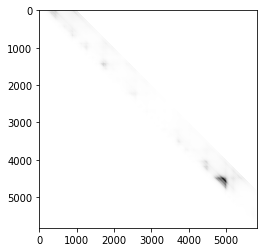

In [140]:
plt.imshow(pscore_matrix, cmap='Greys')

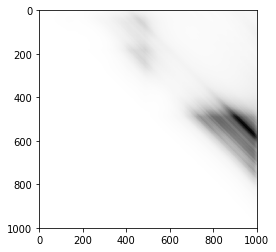

In [141]:
ws, we = 4000, 5000
plt.imshow(pscore_matrix[ws:we,ws:we], cmap='Greys')

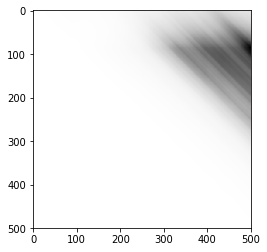

In [142]:
ws, we = 4400, 4900
plt.imshow(pscore_matrix[ws:we,ws:we], cmap='Greys')

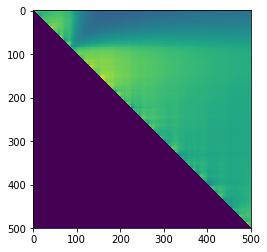

In [143]:
plt.imshow(real_means[ws:we,ws:we])

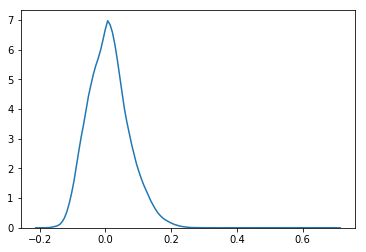

In [144]:
seaborn.kdeplot(shuffled_means[3])

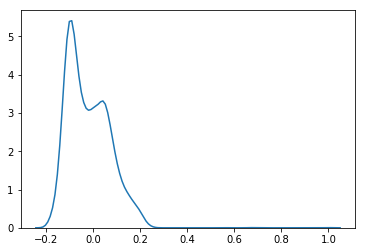

In [145]:
seaborn.kdeplot(trimmed_corrs[4400])

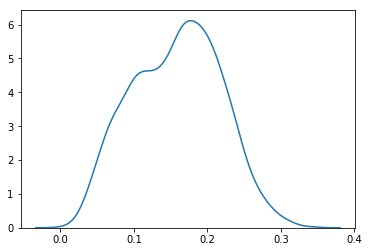

In [146]:
seaborn.kdeplot(numpy.diag(real_means, 2))

In [147]:
real_means[ws:we,ws:we]

array([[0.        , 0.        , 0.24012106, ..., 0.10454358, 0.10452145,
        0.10453651],
       [0.        , 0.        , 0.        , ..., 0.1051662 , 0.10514314,
        0.10515761],
       [0.        , 0.        , 0.        , ..., 0.10579427, 0.10577028,
        0.10578411],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.18666568],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [148]:
pscore_matrix[ws:we,ws:we]

array([[   0.        ,    0.        ,    8.69760534, ..., 1503.30924182,
        1494.1292757 , 1481.82026223],
       [   0.        ,    0.        ,    0.        , ..., 1532.07750468,
        1521.82584037, 1513.63469748],
       [   0.        ,    0.        ,    0.        , ..., 1564.83727073,
        1550.99989513, 1541.7453905 ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    6.37651571],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [149]:
print(pscore_matrix[ws:we,ws:we])

[[   0.            0.            8.69760534 ... 1503.30924182
  1494.1292757  1481.82026223]
 [   0.            0.            0.         ... 1532.07750468
  1521.82584037 1513.63469748]
 [   0.            0.            0.         ... 1564.83727073
  1550.99989513 1541.7453905 ]
 ...
 [   0.            0.            0.         ...    0.
     0.            6.37651571]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]


In [97]:
reload(peas.fitapproxdistros.distributions)

<module 'peas.fitapproxdistros.distributions' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/fitapproxdistros/distributions.py'>

In [151]:
pval_matrix = peas.region_stats.compute_pvalues_matrix(real_means, null_distributions, tail='right', diagonal_start=1, diagonal_end=999)

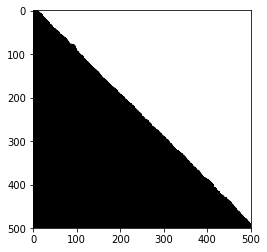

In [156]:
plt.imshow(pval_matrix[ws:we,ws:we], vmin=0, vmax=0.00000001, cmap='Greys')

In [159]:
pval_matrix[ws:we,ws:we]

array([[1.00000000e+00, 5.28196757e-01, 1.66985206e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 5.28196757e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 5.28196757e-01, 1.70103955e-03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 5.28196757e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [160]:
edge_weights = pscore_matrix

## Filtering

## Choosing

In [ ]:
regions = peas.choosing.pick_regions(edge_weights, )